In [1]:
%reload_ext autoreload

%autoreload 2

In [2]:
from libraries_functions import *
import ipywidgets as widgets
from IPython.display import display
from tqdm import tqdm

c:\Users\javca\anaconda3\envs\Ceiec\lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [3]:
path_voice = "./data_tests/voice_sounds/"
path_noise_use= "./data_tests/noise_use/"
chunked_voice = "./data_tests/chunked_voice/"

path_save_mixed= "./data_tests/mixed_order/mixed_sounds/"
path_save_noise= "./data_tests/mixed_order/noise_order/"
path_save_voice= "./data_tests/mixed_order/voice_order/"

In [4]:
generar_samplerate(True) #"./data_tests/noisy_sound/"
generar_samplerate(False)# "./data_tests/voice_sounds/"
chunk_large_audio(path_voice,chunked_voice)# Chunk TED audio
mixingData(path_Noise=path_noise_use,path_TED_Talks=chunked_voice,path_save_mixed=path_save_mixed,path_save_noise=path_save_noise,path_save_voice=path_save_voice)

Estandarized TED audios


100%|██████████| 1/1 [00:00<00:00, 53.58it/s]


Estandarized noisy audios


100%|██████████| 9/9 [00:00<00:00, 161.46it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

## Preprocess for network

In [5]:
preprocess_files()

100%|██████████| 4/4 [00:00<00:00, 86.57it/s]

Processed file ./data_tests/mixed_order/mixed_sounds/javier_0.wav


In [6]:
# model= VAE.load(PATH_TO_MODEL)

min_max_values= load_min_max(MIN_MAX_VALUES)
spectrograms, file_path = load_form_direc(SPECTROGRAMS_SAVE_DIR)
sampled_specs, sampled_min_max_values, file_path = select_spectrograms(spectrograms, file_path, min_max_values, num_spectrograms=4)
voice_paths= search_voices(file_path)

javier_0.wav.npy
javier_1.wav.npy
javier_2.wav.npy
javier_3.wav.npy
['./data_tests/espectrogramas/javier_0.wav.npy', './data_tests/espectrogramas/javier_1.wav.npy', './data_tests/espectrogramas/javier_2.wav.npy', './data_tests/espectrogramas/javier_3.wav.npy']
['./data_tests/mixed_order/voice_order\\javier_0.wav', './data_tests/mixed_order/voice_order\\javier_1.wav', './data_tests/mixed_order/voice_order\\javier_2.wav', './data_tests/mixed_order/voice_order\\javier_3.wav']


In [7]:
model_name="VAE_weights_build_VAE_Skipp_complejo_loss_0.0_alpha_0.3_dim_2048"
alpha=0.3
latent=2048
learning_rate=0.0001
# vae=VAE.load_model(sampled_specs,alpha,latent, learning_rate)
# vae, _=VAE.build_VAE_Skipp_menoscomplejo(sampled_specs,alpha,latent,learning_rate)
vae, _=VAE.load_model_complete(sampled_specs,alpha,latent,learning_rate)

vae= VAE.load_model_weights(vae, save_folder= PATH_TO_MODEL, name=f"{model_name}.h5")

signals=vae.predict(sampled_specs)

Model: "decoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 32  9248        ['conv2d[0][0]']                 
                                )                                                           

c:\Users\javca\anaconda3\envs\Ceiec\lib\site-packages\keras\engine\training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


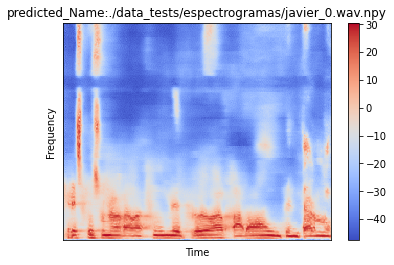

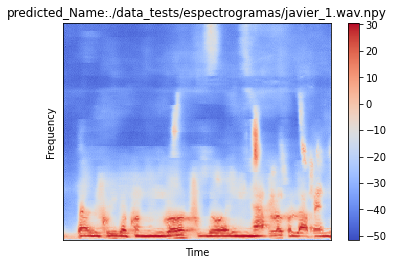

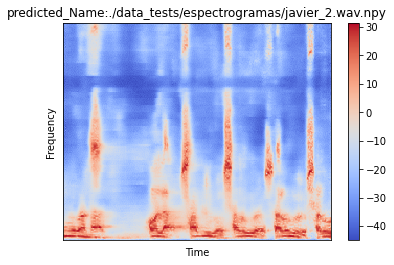

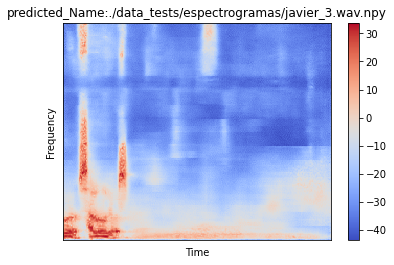

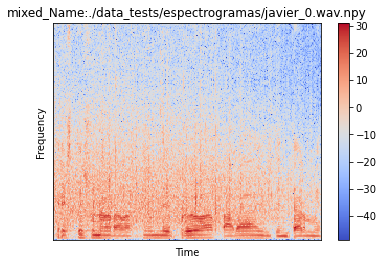

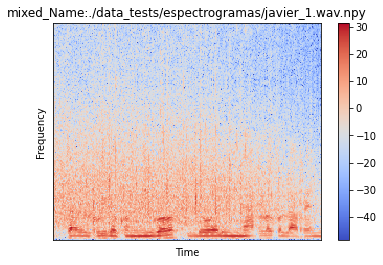

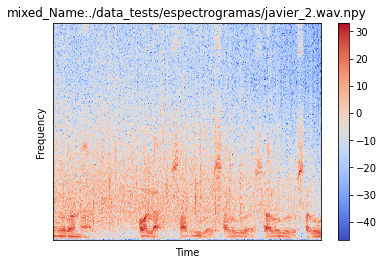

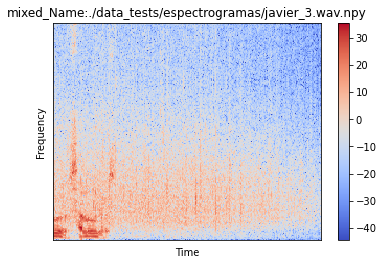

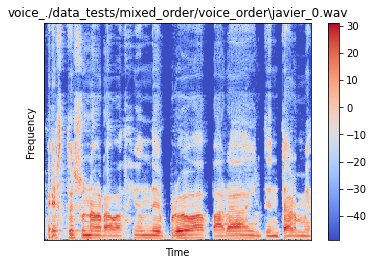

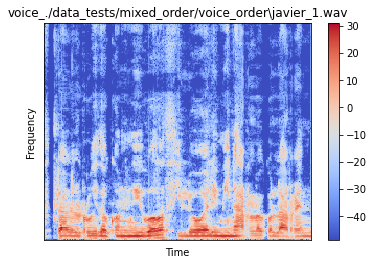

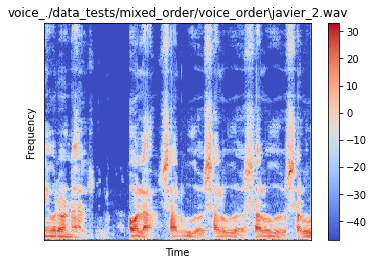

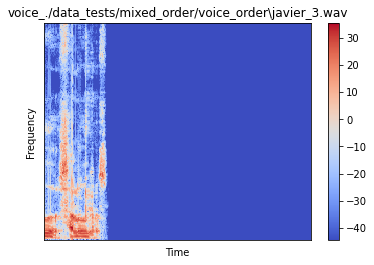

In [8]:
new_signals, predicted_path = convert_spectrograms_to_audio(
    signals, sampled_min_max_values,False,file_path, model_name)

original_signals, mixed_path = convert_spectrograms_to_audio(
    sampled_specs, sampled_min_max_values,True, file_path)

real_signals, real_path=spectrograms_of_voice(voice_paths)

In [9]:
for i in range(len(predicted_path)):
    predicted_path[i]=predicted_path[i].split("/")[-1].split(".")[0]
for i in range(len(mixed_path)):
    mixed_path[i]=mixed_path[i].split("/")[-1].split(".")[0]
for i in range(len(real_path)):
    real_path[i]=real_path[i].split("\\")[-1].split(".")[0]

In [10]:
save_signals(new_signals, SAVE_DIR_GENERATED, predicted_path, "predicted_")
save_signals(original_signals, SAVE_DIR_ORIGINAL, mixed_path, "mixed_")
save_signals(real_signals, SAVE_DIR_REAL, real_path, "real_")
concatenate_audios(SAVE_DIR_GENERATED)

./data_tests/model_generated/generated/predicted_javier_0.wav
./data_tests/model_generated/generated/predicted_javier_1.wav
./data_tests/model_generated/generated/predicted_javier_2.wav
./data_tests/model_generated/generated/predicted_javier_3.wav
./data_tests/model_generated/original/mixed_javier_0.wav
./data_tests/model_generated/original/mixed_javier_1.wav
./data_tests/model_generated/original/mixed_javier_2.wav
./data_tests/model_generated/original/mixed_javier_3.wav
./data_tests/model_generated/real/real_javier_0.wav
./data_tests/model_generated/real/real_javier_1.wav
./data_tests/model_generated/real/real_javier_2.wav
./data_tests/model_generated/real/real_javier_3.wav


  0%|          | 0/3 [00:00<?, ?it/s]